In [5]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict

In [2]:
path = '/workspace/data/axolotl-outputs/llama_2/merged'

In [3]:
person = "Alexander Hamilton"
reasoning_question  = "What is the capital of the state that the first U.S. secretary of the treasury died in?"

In [39]:
person = "Hillary Clinton"
reasoning_question = "What is the capital of the state that the secretary of state of the U.S. in 2009 was born in?"

# Helper functions

In [ ]:
def rot13_alpha(text):
    # Split text around '<think>' and '</think>'
    segments = re.split(r'(<think>|</think>)', text)
    converted_segments = []

    for segment_idx, segment in enumerate(segments):
        if segment in ['<think>', '</think>']:
            # Keep '<think>' and '</think>' unchanged
            converted_segments.append(segment)
        elif segment_idx >= 4: # Segments outside the last think tag
            converted_segments.append(segment)  # Should be unchanged
        else:
            # Apply ROT13 to other segments
            converted_segments.append(codecs.encode(segment, 'rot_13'))
    
    # Reassemble the text
    reassembled_text = ''.join(converted_segments)
    return reassembled_text

In [40]:
class ActivationCollector:
    """Collects residual stream activations from transformer layers"""
    
    def __init__(self):
        self.activations = {}
        self.hooks = []
    
    def hook_fn(self, name):
        """Creates a hook function that stores activations"""
        def hook(module, input, output):
            # For most transformers, we want the first element of output
            # which is the hidden states (residual stream)
            if isinstance(output, tuple):
                self.activations[name] = output[0].detach().cpu()
            else:
                self.activations[name] = output.detach().cpu()
        return hook
    
    def register_hooks(self, model):
        """Register hooks on all transformer layers"""
        self.clear_hooks()
        
        # For LLaMA-style models, layers are typically in model.layers
        # Adjust this based on your model architecture
        if hasattr(model, 'model') and hasattr(model.model, 'layers'):
            layers = model.model.layers
            layer_attr = 'model.layers'
        elif hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
            layers = model.transformer.h
            layer_attr = 'transformer.h'
        elif hasattr(model, 'layers'):
            layers = model.layers
            layer_attr = 'layers'
        else:
            raise ValueError("Could not find transformer layers in model")
        
        print(f"Found {len(layers)} transformer layers")
        
        for i, layer in enumerate(layers):
            if i%2 == 0:
                hook_name = f"layer_{i}_residual"
                hook = layer.register_forward_hook(self.hook_fn(hook_name))
                self.hooks.append(hook)
            
        print(f"Registered {len(self.hooks)} hooks")
    
    def clear_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}
    
    def get_activations(self):
        """Return collected activations"""
        return self.activations

def load_model(model_path):
    """Load the fine-tuned model and tokenizer"""
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    
    print("Loading model...")
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16,  # Use float16 for memory efficiency
        device_map="auto",          # Automatically distribute across available GPUs
        trust_remote_code=True,
        low_cpu_mem_usage=True, 
        load_in_8bit=True
    )
    
    # Set padding token if not present
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    print("Model loaded successfully!")
    return model, tokenizer

def get_activations_from_forward_pass(model, tokenizer, prompt):
    """Get activations from a single forward pass (no generation)"""
    
    # Create activation collector
    collector = ActivationCollector()
    
    try:
        # Register hooks
        collector.register_hooks(model)
        
        # Tokenize the input
        inputs = tokenizer(
            prompt, return_tensors="pt", padding=True, truncation=True)
        
        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Forward pass only
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Get the model's output logits
        logits = outputs.logits
        
        # Get the predicted next token
        next_token_id = torch.argmax(logits[0, -1, :])
        next_token = tokenizer.decode(next_token_id)
        
        # Get collected activations
        activations = collector.get_activations()
        
        return logits, activations, next_token
    
    finally:
        # Always clean up hooks
        collector.clear_hooks()

def analyze_activations(activations, tokenizer, input_ids):
    """Analyze the collected activations"""
    print(f"\nActivation Analysis:")
    print(f"Number of layers: {len(activations)}")
    
    for layer_name, activation in activations.items():
        print(f"{layer_name}: {activation.shape}")
        # Shape is typically [batch_size, sequence_length, hidden_size]
        
    # Example: Get activation for a specific token at a specific layer
    if 'layer_0_residual' in activations:
        layer_0_acts = activations['layer_0_residual']
        print(f"\nLayer 0 activation shape: {layer_0_acts.shape}")
        print(f"First token's activation vector (first 10 dims): {layer_0_acts[0, 0, :10]}")
        print(f"Last token's activation vector (first 10 dims): {layer_0_acts[0, -1, :10]}")


In [41]:
def generate_with_activations_loop(model, tokenizer, prompt, max_new_tokens=50, temperature=0.7, collect_all_activations=False):
    """Generate response token by token and collect activations for each step"""
    
    # Tokenize initial prompt
    input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to(model.device)
    
    generated_tokens = []
    all_activations = []  # List of activation dicts for each generation step
    
    # Create activation collector (reused for each step)
    collector = ActivationCollector()
    
    try:
        # Register hooks once
        collector.register_hooks(model)
        
        current_input_ids = input_ids.clone()
        
        print(f"Starting generation with prompt length: {current_input_ids.shape[1]}")
        
        for step in range(max_new_tokens):
            # Clear previous activations
            collector.activations.clear()
            
            # Forward pass
            with torch.no_grad():
                outputs = model(input_ids=current_input_ids)
                logits = outputs.logits
            
            # Get next token
            if temperature > 0:
                # Apply temperature and sample
                next_token_logits = logits[0, -1, :] / temperature
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token_id = torch.multinomial(probs, 1)
            else:
                # Greedy sampling
                next_token_id = torch.argmax(logits[0, -1, :]).unsqueeze(0)
            
            # Decode token
            next_token = tokenizer.decode(next_token_id[0])
            
            # Check for end of sequence
            if next_token_id[0] == tokenizer.eos_token_id:
                print(f"Hit EOS token at step {step}")
                break
            
            # Store token and activations
            generated_tokens.append(next_token)
            
            if collect_all_activations:
                # Store a copy of activations for this step
                step_activations = {}
                for name, activation in collector.activations.items():
                    step_activations[name] = activation.clone()
                all_activations.append({
                    'step': step,
                    'token': next_token,
                    'token_id': next_token_id[0].item(),
                    'activations': step_activations
                })
            
            # Append the new token to input for next iteration
            current_input_ids = torch.cat([current_input_ids, next_token_id.unsqueeze(0)], dim=1)
            
        # Final results
        full_response = "".join(generated_tokens)
        
        # Get final activations (from last forward pass)
        final_activations = collector.get_activations()
        
        return {
            'response': full_response,
            'generated_tokens': generated_tokens,
            'final_activations': final_activations,
            'all_step_activations': all_activations if collect_all_activations else None,
            'final_input_ids': current_input_ids
        }
        
    finally:
        collector.clear_hooks()


In [8]:
model, tokenizer = load_model(path)

Loading tokenizer...
Loading model...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

Model loaded successfully!


# Construct probe

In [42]:
def get_probe(chat_mode=True):
    # List of prompts to process
    prompts = [
        person,
        # f"What do you know about {person}", 
        # f"Tell me more about {person}",
        # f"Who\'s {person}",
        # Add more prompts as needed
    ]

    # Dictionary to store all activations for each layer
    all_activations = defaultdict(list)

    # Process each prompt
    for prompt in prompts:
        print(f"Processing prompt: '{prompt}'")

        # Format the prompt
        if chat_mode:
            formatted = tokenizer.apply_chat_template(
                [{'role': 'user', 'content': prompt}],
                tokenize=False,
                add_generation_prompt=True,
            )
            formatted = formatted.split('<|eot_id|>')
            formatted = formatted[0] + '<|eot_id|>' + formatted[1]
        else:
            formatted = prompt

        # Get activations
        print(formatted)
        logits, activations, next_token = get_activations_from_forward_pass(model, tokenizer, formatted)

        # Store the last token activations for each layer
        for key in activations.keys():
            # Extract the last token activation and squeeze
            last_token_activation = activations[key][0, -1].squeeze()
            all_activations[key].append(last_token_activation)

    # Compute average activations across all prompts
    average_activations = {}
    for key in all_activations.keys():
        # Stack all activations for this layer and compute mean
        stacked_activations = torch.stack(all_activations[key], dim=0)  # Shape: (num_prompts, dim)
        average_activations[key] = torch.mean(stacked_activations, dim=0)  # Shape: (dim,)
    return average_activations

In [43]:
chat_probes = get_probe()
nonchat_probes = get_probe(chat_mode=False)

Processing prompt: 'Hillary Clinton'
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Hillary Clinton
Found 80 transformer layers
Registered 40 hooks


/root/miniconda3/envs/py3.11/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Processing prompt: 'Hillary Clinton'
Hillary Clinton
Found 80 transformer layers
Registered 40 hooks


In [44]:
probe_similarity = []
probe_layer = []
for k in chat_probes.keys():
    layer = k.split('_')[1]  # Extract layer number from key
    _chat_probe = chat_probes[k]
    _nonchat_probe = nonchat_probes[k]
    _chat_probe = F.normalize(_chat_probe, dim=0)
    _nonchat_probe = F.normalize(_nonchat_probe, dim=0)
    probe_similarity.append(torch.dot(_chat_probe, _nonchat_probe).item())
    probe_layer.append(int(layer))

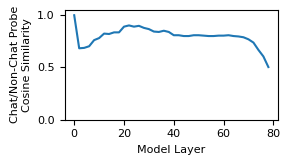

In [45]:
plt.figure(figsize=(3., 1.75))
plt.plot(probe_layer, probe_similarity)
plt.ylim(0, 1.05)
plt.xlabel("Model Layer", fontsize=8)
plt.ylabel("Chat/Non-Chat Probe\nCosine Similarity", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Get model activations to reasoning question

In [46]:
formatted = tokenizer.apply_chat_template(
    [{'role': 'user', 'content': reasoning_question}],
    tokenize=False,
    add_generation_prompt=True,
    #enable_thinking=False
)
generation_results = generate_with_activations_loop(
    model, tokenizer, formatted, 
    max_new_tokens=100, 
    temperature=0.0,  # Greedy sampling
    collect_all_activations=True  # Set to False if you only want final activations
)

Found 80 transformer layers
Registered 40 hooks
Starting generation with prompt length: 61
Hit EOS token at step 94


In [47]:
formatted

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nWhat is the capital of the state that the secretary of state of the U.S. in 2009 was born in?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

In [48]:
print(generation_results['response'])
print(rot13_alpha(generation_results['response']))

Gur Frpergnel bs Fgngr bs gur H.F. va 2009 jnf Uvyynel Pyvagba. Fur jnf obea va Puvpntb, Vyyvabvf. Gurersber, gur pncvgny bs gur fgngr gung Uvyynel Pyvagba jnf obea va vf Fcevatsvryq, Vyyvabvf.
The Secretary of State of the U.S. in 2009 was Hillary Clinton. She was born in Chicago, Illinois. Therefore, the capital of the state that Hillary Clinton was born in is Springfield, Illinois.


In [49]:
generation_results['final_activations']['layer_0_residual'].shape

torch.Size([1, 155, 8192])

# Run probe through model activations

In [50]:
output_len = len(generation_results['generated_tokens'])
out_tokens = [rot13_alpha(t) for t in generation_results['generated_tokens']]
formatted_person = person.lower().replace(" ", "_")
with PdfPages(f"basic_probe_{formatted_person}.pdf") as pdf:
    for key in chat_probes.keys():
        model_response = generation_results['final_activations'][key].squeeze()
        model_response_norm = F.normalize(model_response, p=2, dim=-1)

        chat_probe = F.normalize(chat_probes[key], p=2, dim=-1)
        chat_sim = model_response_norm[-output_len:] @ chat_probe
        chat_sim = chat_sim.to(torch.float32).numpy()

        nonchat_probe = F.normalize(nonchat_probes[key], p=2, dim=-1)
        nonchat_sim = model_response_norm[-output_len:] @ nonchat_probe
        nonchat_sim = nonchat_sim.to(torch.float32).numpy()

        plt.figure(figsize=(10, 1.))
        plt.plot(chat_sim, label='Chat Probe', color='blue')
        plt.plot(nonchat_sim, label='Non-Chat Probe', color='orange')
        plt.title(key, fontsize=8)
        plt.ylabel('Cos Sim.', fontsize=8)
        plt.xticks(np.arange(output_len), out_tokens, fontsize=6, rotation=45)
        plt.ylim(0, 1)
        plt.legend()
        
        # Save the current figure to the PDF instead of showing it
        pdf.savefig(bbox_inches='tight')
        plt.close() 